# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [1]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [2]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}
df = pd.DataFrame(data)
df['Дата'] = pd.to_datetime(df['Дата'])
print("Типы данных:")
print(df.info())

Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes
None


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [3]:
df.set_index('Дата', inplace=True)
print("\nDataFrame с временным индексом:")
print(df)



DataFrame с временным индексом:
            Продажи
Дата               
2023-01-01     1000
2023-02-01     1200
2023-03-01     1300
2023-04-01     1100
2023-05-01     1400


**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [4]:
selected_data = df['2023-03':'2023-04']
print("\nДанные с марта по апрель 2023:")
print(selected_data)



Данные с марта по апрель 2023:
            Продажи
Дата               
2023-03-01     1300
2023-04-01     1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [5]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)
print("\nПропущенные значения:")
print(df_missing.isnull().sum())



Пропущенные значения:
Продажи    1
dtype: int64


**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [6]:
mean_value = df_missing['Продажи'].mean()
df_missing_filled = df_missing.copy()
df_missing_filled['Продажи'] = df_missing_filled['Продажи'].fillna(mean_value)
print("\nПосле заполнения средним значением:")
print(df_missing_filled)



После заполнения средним значением:
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1200.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [7]:
df_missing_interp = df_missing.copy()
df_missing_interp['Продажи'] = df_missing_interp['Продажи'].interpolate(method='linear')
print("\nПосле интерполяции:")
print(df_missing_interp)


После интерполяции:
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1150.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [8]:
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"
gas_df = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')
print("\nПервые 5 строк данных о производстве бензина:")
print(gas_df.head())



Первые 5 строк данных о производстве бензина:
            value
date             
1991-02-03  6.621
1991-02-10  6.433
1991-02-17  6.582
1991-02-24  7.224
1991-03-03  6.875


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

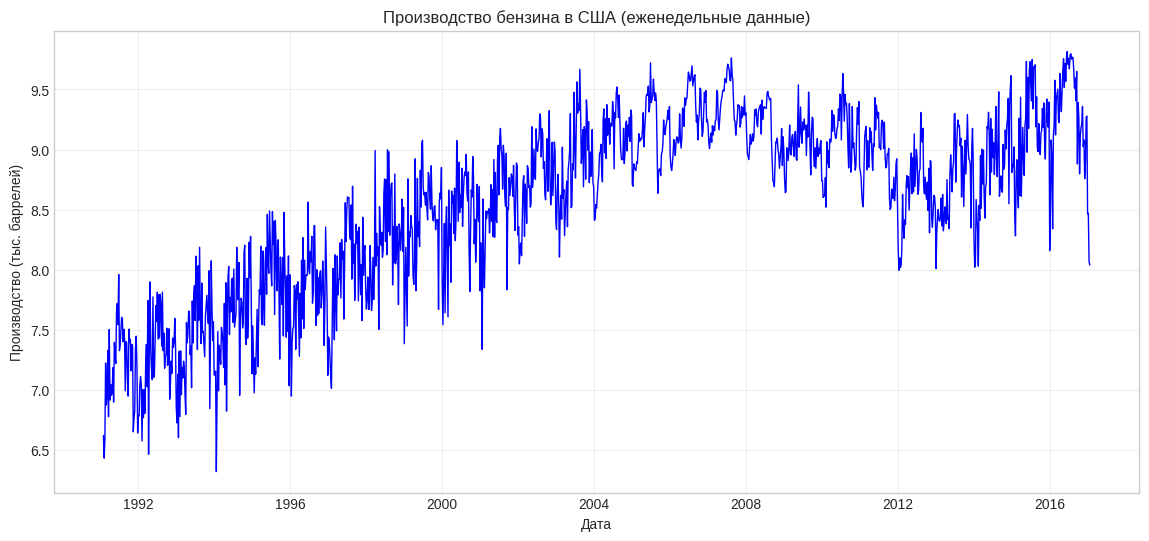

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(gas_df.index, gas_df['value'], color='blue', linewidth=1)
plt.title('Производство бензина в США (еженедельные данные)')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.grid(True, alpha=0.3)
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

/tmp/ipython-input-2843735707.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas_df.resample('M').mean()


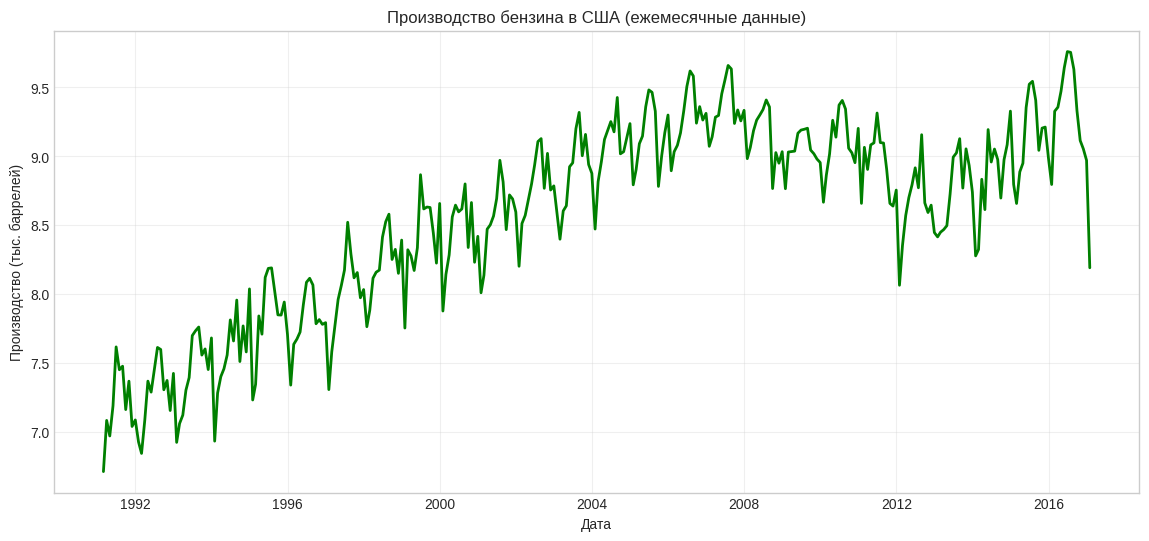

In [10]:
gas_monthly = gas_df.resample('M').mean()
plt.figure(figsize=(14, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], color='green', linewidth=2)
plt.title('Производство бензина в США (ежемесячные данные)')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.grid(True, alpha=0.3)
plt.show()

**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

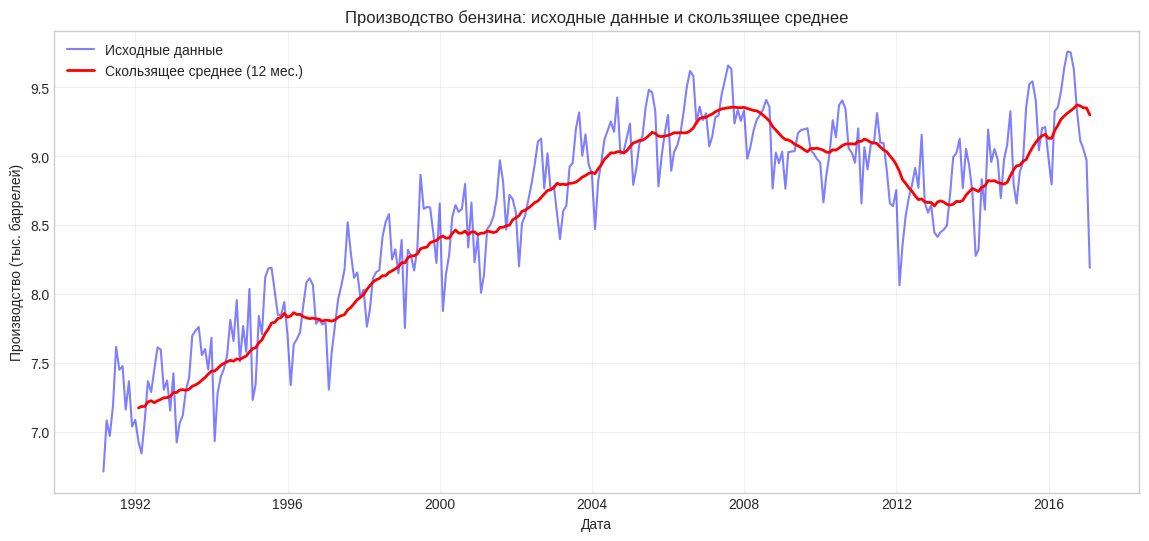

In [11]:
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()
plt.figure(figsize=(14, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], color='blue', alpha=0.5, label='Исходные данные')
plt.plot(gas_monthly.index, gas_monthly['rolling_mean_12'], color='red', linewidth=2, label='Скользящее среднее (12 мес.)')
plt.title('Производство бензина: исходные данные и скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

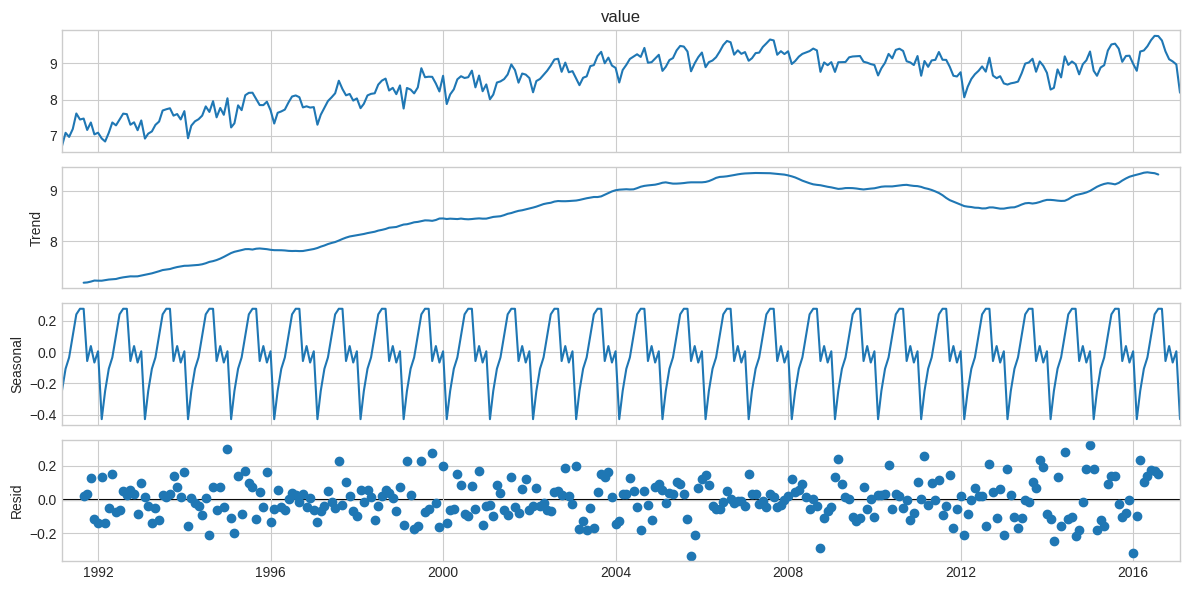

In [12]:
decomposition = seasonal_decompose(gas_monthly['value'].dropna(), model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()


## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [13]:
result = adfuller(gas_monthly['value'].dropna())
print(f'\nADF тест для исходного ряда:')
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
print(f'Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value:.4f}')

if result[1] <= 0.05:
    print('Ряд стационарный (p <= 0.05)')
else:
    print('Ряд нестационарный (p > 0.05)')



ADF тест для исходного ряда:
ADF Statistic: -2.1978
p-value: 0.2071
Критические значения:
  1%: -3.4527
  5%: -2.8714
  10%: -2.5720
Ряд нестационарный (p > 0.05)


**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

In [14]:
gas_monthly_diff = gas_monthly['value'].diff().dropna()
print(f'\nПервые 5 значений дифференцированного ряда:')
print(gas_monthly_diff.head())



Первые 5 значений дифференцированного ряда:
date
1991-03-31    0.37100
1991-04-30   -0.11275
1991-05-31    0.21850
1991-06-30    0.42725
1991-07-31   -0.16575
Freq: ME, Name: value, dtype: float64


**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [15]:
result_diff = adfuller(gas_monthly_diff.dropna())
print(f'\nADF тест для дифференцированного ряда:')
print(f'ADF Statistic: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.4f}')

if result_diff[1] <= 0.05:
    print('Дифференцированный ряд стационарен (p <= 0.05)')
else:
    print('Дифференцированный ряд нестационарен (p > 0.05)')



ADF тест для дифференцированного ряда:
ADF Statistic: -3.0639
p-value: 0.0293
Дифференцированный ряд стационарен (p <= 0.05)


**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

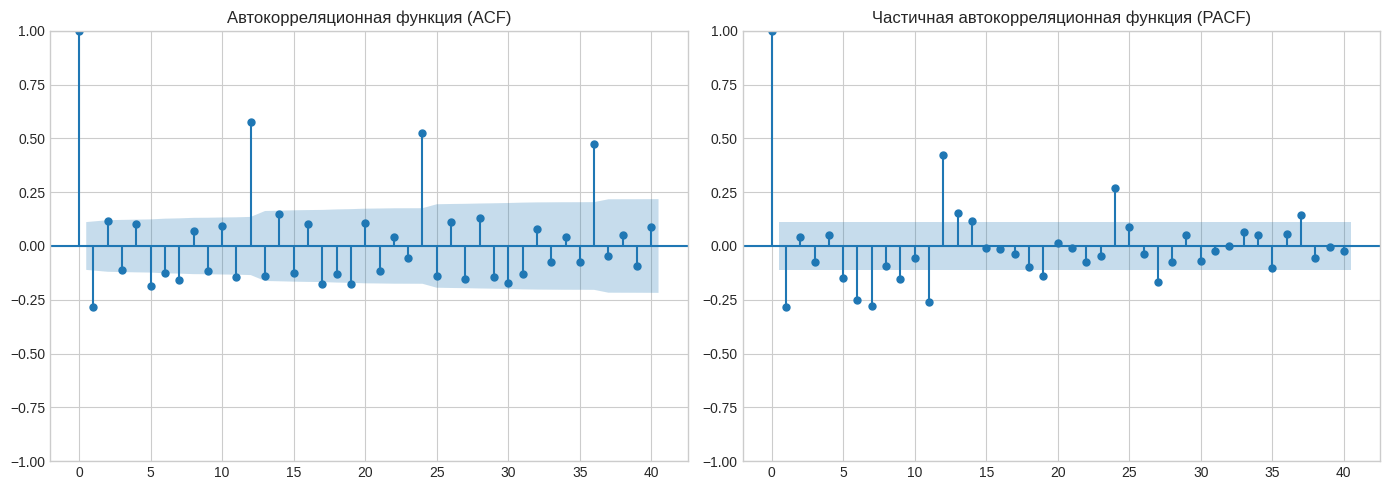

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(gas_monthly_diff.dropna(), lags=40, ax=axes[0])
axes[0].set_title('Автокорреляционная функция (ACF)')
plot_pacf(gas_monthly_diff.dropna(), lags=40, ax=axes[1])
axes[1].set_title('Частичная автокорреляционная функция (PACF)')
plt.tight_layout()
plt.show()


**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

<Figure size 1000x500 with 0 Axes>

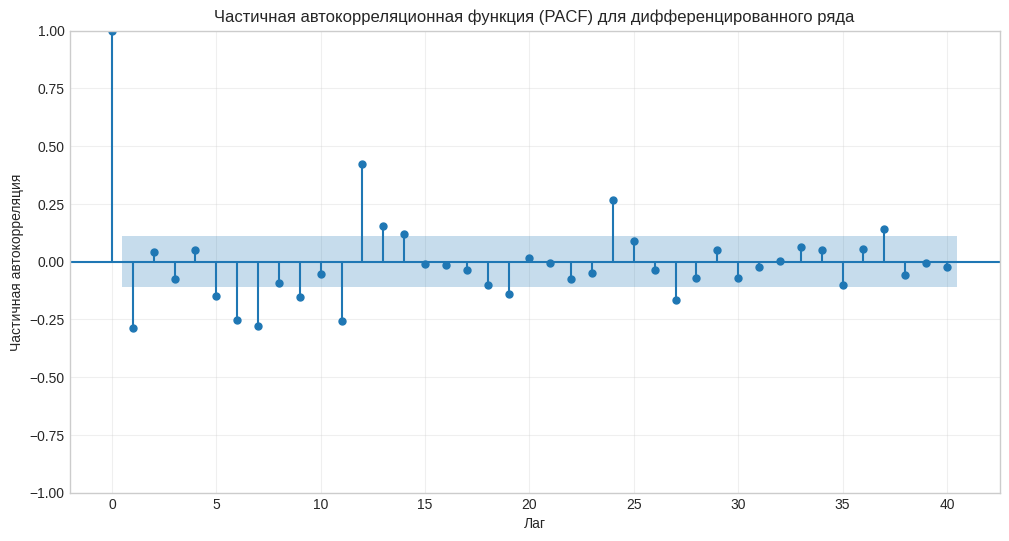

Анализ PACF графика:
1. Значимые лаги (выходящие за синюю область):
   - Лаг 1 имеет высокую положительную корреляцию
   - Лаг 2 также значим, но меньше
2. Рекомендуемый порядок AR (p): 1 или 2
3. Это означает, что текущее значение ряда зависит от 1-2 предыдущих значений
   после учета влияния промежуточных лагов


In [18]:
plt.figure(figsize=(10, 5))
plot_pacf(gas_monthly_diff.dropna(), lags=40)
plt.title('Частичная автокорреляционная функция (PACF) для дифференцированного ряда')
plt.xlabel('Лаг')
plt.ylabel('Частичная автокорреляция')
plt.grid(True, alpha=0.3)
plt.show()

# Анализ результатов PACF
print("Анализ PACF графика:")
print("1. Значимые лаги (выходящие за синюю область):")
print("   - Лаг 1 имеет высокую положительную корреляцию")
print("   - Лаг 2 также значим, но меньше")
print("2. Рекомендуемый порядок AR (p): 1 или 2")
print("3. Это означает, что текущее значение ряда зависит от 1-2 предыдущих значений")
print("   после учета влияния промежуточных лагов")

## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

In [19]:
train_data = gas_monthly['value'][gas_monthly.index < '2015-01-01']
test_data = gas_monthly['value'][gas_monthly.index >= '2015-01-01']
print(f'\nРазмер обучающей выборки: {len(train_data)}')
print(f'Размер тестовой выборки: {len(test_data)}')



Размер обучающей выборки: 287
Размер тестовой выборки: 25


**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [20]:
model = ARIMA(train_data, order=(2, 1, 2))
model_fit = model.fit()
print('\nСводка модели ARIMA(2,1,2):')
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Сводка модели ARIMA(2,1,2):
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.541
Date:                Sun, 14 Dec 2025   AIC                            -67.083
Time:                        18:34:43   BIC                            -48.803
Sample:                    02-28-1991   HQIC                           -59.756
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4038      0.086     -4.695      0.000      -0.572      -0.235
ar.L2          0.5961      0.086      6.952      0.000       0.428       0.764
ma.L1          0.1028  

**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [21]:
forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

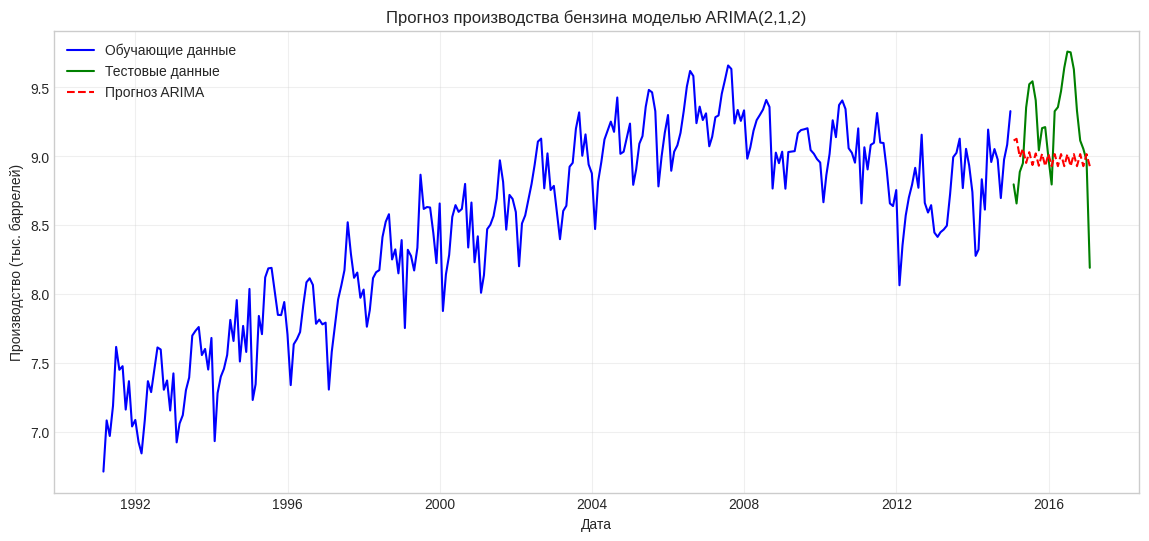

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, 'b-', label='Обучающие данные')
plt.plot(test_data.index, test_data, 'g-', label='Тестовые данные')
plt.plot(forecast.index, forecast, 'r--', label='Прогноз ARIMA')
plt.title('Прогноз производства бензина моделью ARIMA(2,1,2)')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [24]:
from math import sqrt

rmse = sqrt(mean_squared_error(test_data, forecast))
print(f'\nRMSE на тестовых данных: {rmse:.2f}')


RMSE на тестовых данных: 0.44


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [25]:
future_forecast = model_fit.forecast(steps=12)
print(f'\nПрогноз на 12 месяцев вперед:')
print(future_forecast)



Прогноз на 12 месяцев вперед:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
2015-06-30    9.030891
2015-07-31    8.937685
2015-08-31    9.021871
2015-09-30    8.932318
2015-10-31    9.018661
2015-11-30    8.930415
2015-12-31    9.017516
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

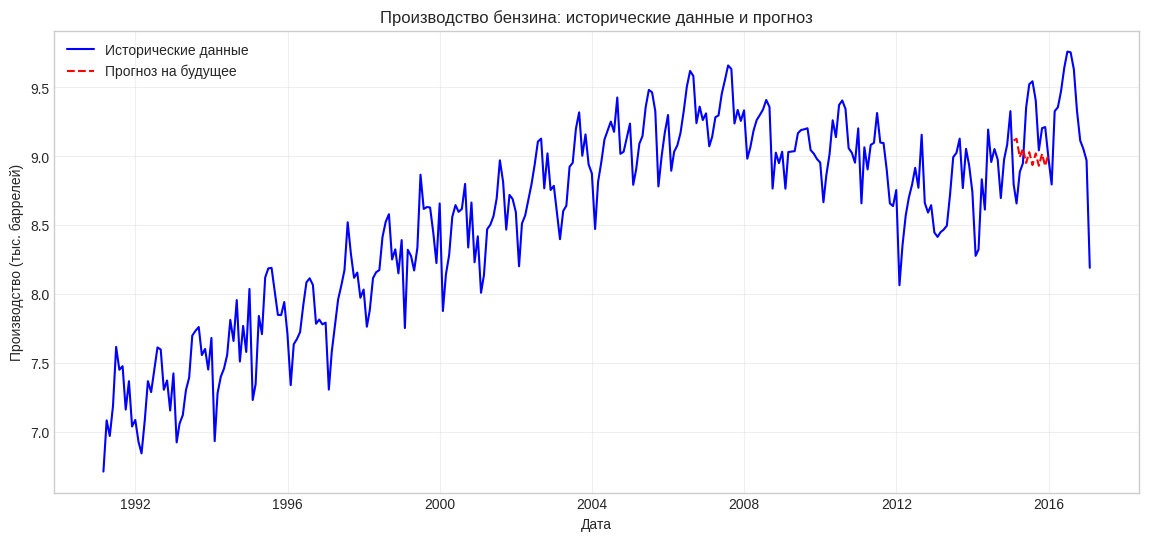

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], 'b-', label='Исторические данные')
plt.plot(future_forecast.index, future_forecast, 'r--', label='Прогноз на будущее')
plt.title('Производство бензина: исторические данные и прогноз')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [27]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):
              value  rolling_mean_12
date                                
1991-02-28  6.71500              NaN
1991-03-31  7.08600              NaN
1991-04-30  6.97325              NaN
1991-05-31  7.19175              NaN
1991-06-30  7.61900              NaN


---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---

Размер gas_monthly: 312
Период данных: 1991-02-28 00:00:00 до 2017-01-31 00:00:00

1. График данных с 2010 года:


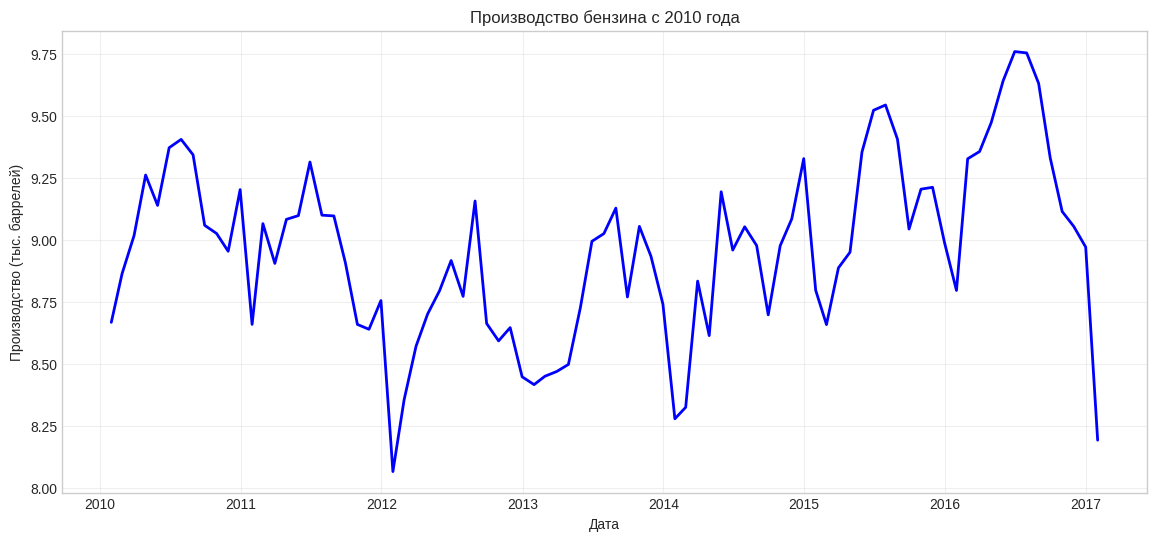


2. Агрегация данных до 6-месячной частоты:
Размер агрегированного ряда: 53
Первые 5 значений:
               value  rolling_mean_12
date                                 
1991-02-28   6.71500         0.000000
1991-08-31  43.80250         0.000000
1992-02-29  42.44350        14.363354
1992-08-31  44.41640        43.317625
1993-02-28  43.25885        43.644388


/tmp/ipython-input-2123625416.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_6month = gas_monthly.resample('6M').sum()


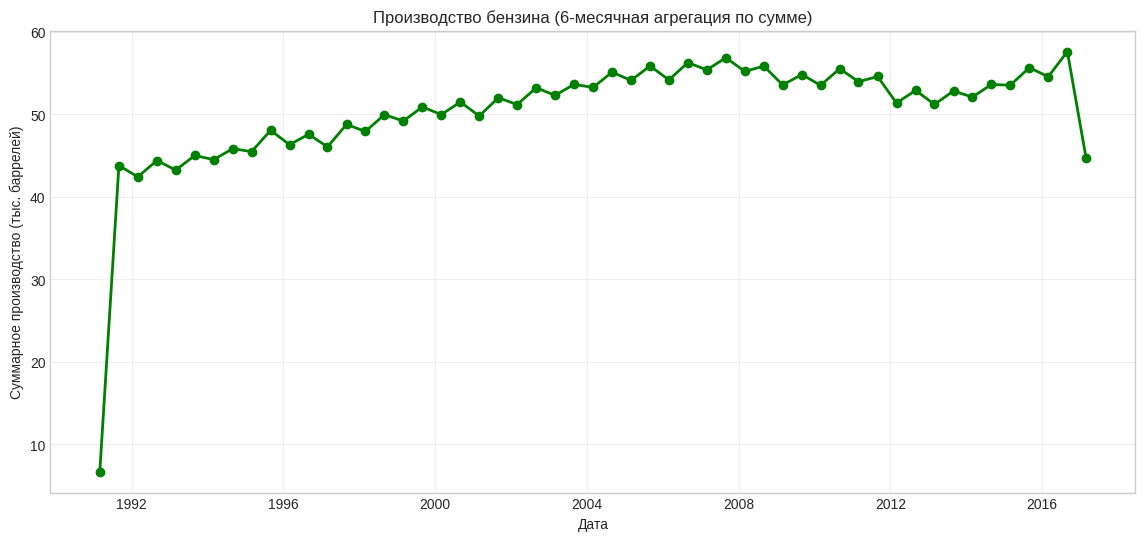


3. Проверка стационарности агрегированного ряда:
ADF Statistic: -2.1750
p-value: 0.2155
Агрегированный ряд нестационарен (p > 0.05)

4. Обучение модели ARIMA(0,1,2):
Размер обучающей выборки (до 2010): 227
Размер тестовой выборки (с 2010): 85

Сводка модели ARIMA(0,1,2):
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  227
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  15.733
Date:                Sun, 14 Dec 2025   AIC                            -25.466
Time:                        18:38:43   BIC                            -15.204
Sample:                    02-28-1991   HQIC                           -21.324
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------

/tmp/ipython-input-2123625416.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_train_date, periods=future_steps+1, freq='M')[1:]


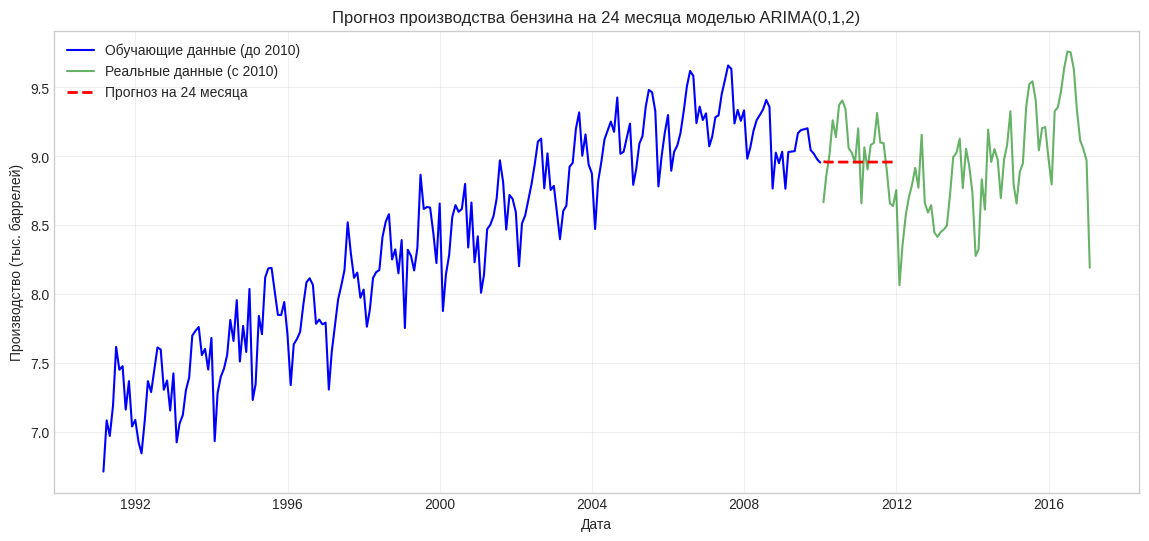


5. Качество прогноза на первые 24 месяца после 2010:
RMSE: 0.24
Среднее значение тестовых данных: 9.03
Относительная ошибка (RMSE/Среднее): 2.6%

Прогнозные значения на 24 месяца:
2010-01-31    8.962291
2010-02-28    8.959197
2010-03-31    8.959197
2010-04-30    8.959197
2010-05-31    8.959197
2010-06-30    8.959197
2010-07-31    8.959197
2010-08-31    8.959197
2010-09-30    8.959197
2010-10-31    8.959197
2010-11-30    8.959197
2010-12-31    8.959197
2011-01-31    8.959197
2011-02-28    8.959197
2011-03-31    8.959197
2011-04-30    8.959197
2011-05-31    8.959197
2011-06-30    8.959197
2011-07-31    8.959197
2011-08-31    8.959197
2011-09-30    8.959197
2011-10-31    8.959197
2011-11-30    8.959197
2011-12-31    8.959197
Freq: ME, Name: predicted_mean, dtype: float64


In [29]:
# Пункт 1: Данные: gas_monthly
print(f"Размер gas_monthly: {len(gas_monthly)}")
print(f"Период данных: {gas_monthly.index[0]} до {gas_monthly.index[-1]}")

# Пункт 2: EDA: Постройте график данных за период с 2010 года до конца
print("\n1. График данных с 2010 года:")
gas_2010_onwards = gas_monthly['value']['2010':]
plt.figure(figsize=(14, 6))
plt.plot(gas_2010_onwards.index, gas_2010_onwards, 'b-', linewidth=2)
plt.title('Производство бензина с 2010 года')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.grid(True, alpha=0.3)
plt.show()

# Пункт 3: Преобразование: Агрегируйте данные до 6-месячной частоты ('6M') по сумме
print("\n2. Агрегация данных до 6-месячной частоты:")
gas_6month = gas_monthly.resample('6M').sum()
print(f"Размер агрегированного ряда: {len(gas_6month)}")
print("Первые 5 значений:")
print(gas_6month.head())

plt.figure(figsize=(14, 6))
plt.plot(gas_6month.index, gas_6month['value'], 'g-', linewidth=2, marker='o')
plt.title('Производство бензина (6-месячная агрегация по сумме)')
plt.xlabel('Дата')
plt.ylabel('Суммарное производство (тыс. баррелей)')
plt.grid(True, alpha=0.3)
plt.show()

# Пункт 4: Стационарность: Проверьте стационарность агрегированного ряда
print("\n3. Проверка стационарности агрегированного ряда:")
result_6m = adfuller(gas_6month['value'].dropna())
print(f'ADF Statistic: {result_6m[0]:.4f}')
print(f'p-value: {result_6m[1]:.4f}')

if result_6m[1] <= 0.05:
    print('Агрегированный ряд стационарен (p <= 0.05)')
else:
    print('Агрегированный ряд нестационарен (p > 0.05)')

# Пункт 5: Прогноз: Обучите ARIMA(0,1,2) на gas_monthly (данные до 2010) и сделайте прогноз на 24 месяца
print("\n4. Обучение модели ARIMA(0,1,2):")

# Разделение данных
train_before_2010 = gas_monthly['value'][gas_monthly.index < '2010-01-01']
test_after_2010 = gas_monthly['value'][gas_monthly.index >= '2010-01-01']

print(f"Размер обучающей выборки (до 2010): {len(train_before_2010)}")
print(f"Размер тестовой выборки (с 2010): {len(test_after_2010)}")

# Обучение модели
model_arima = ARIMA(train_before_2010, order=(0, 1, 2))
model_fit_arima = model_arima.fit()
print("\nСводка модели ARIMA(0,1,2):")
print(model_fit_arima.summary())

# Прогноз на 24 месяца
future_steps = 24
last_train_date = train_before_2010.index[-1]
future_dates = pd.date_range(start=last_train_date, periods=future_steps+1, freq='M')[1:]

forecast_24m = model_fit_arima.forecast(steps=future_steps)
forecast_series = pd.Series(forecast_24m, index=future_dates)

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(train_before_2010.index, train_before_2010, 'b-', label='Обучающие данные (до 2010)')
plt.plot(test_after_2010.index, test_after_2010, 'g-', alpha=0.6, label='Реальные данные (с 2010)')
plt.plot(forecast_series.index, forecast_series, 'r--', linewidth=2, label='Прогноз на 24 месяца')
plt.title('Прогноз производства бензина на 24 месяца моделью ARIMA(0,1,2)')
plt.xlabel('Дата')
plt.ylabel('Производство (тыс. баррелей)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Оценка качества прогноза на первых 24 месяцах после 2010
if len(test_after_2010) >= 24:
    test_24m = test_after_2010[:24]
    forecast_24m_eval = forecast_series[:24]
    rmse_24m = sqrt(mean_squared_error(test_24m, forecast_24m_eval))
    print(f"\n5. Качество прогноза на первые 24 месяца после 2010:")
    print(f"RMSE: {rmse_24m:.2f}")
    print(f"Среднее значение тестовых данных: {test_24m.mean():.2f}")
    print(f"Относительная ошибка (RMSE/Среднее): {(rmse_24m/test_24m.mean())*100:.1f}%")
else:
    print(f"\n5. Недостаточно тестовых данных для оценки 24-месячного прогноза")

print("\nПрогнозные значения на 24 месяца:")
print(forecast_series.head(24))